# STAT 542 - Statistical Learning

# Homework 9 - Manan Mehta (mananm2)

## Due: 11/02/2020

## About HW9

In this homework we will extend the the Gaussian mixture model in the lecture note to a two-dimensional case, where both the mean and variance are unknown. Again, by using the EM algorithm, we face two steps, the E-step that calculates the conditional expectation of the likelihood, and the M-step that update the $\boldsymbol\theta$ estimates. One nontrivial step is to derive analytic solution of $\boldsymbol\theta$ in the M-step, which involves some matrix calculation and tricks. Some hints are provided. Finally, we will implement the method using our own code.

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.stats import multivariate_normal as mvrnorm
import itertools
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

## (100 Points) A Two-dimensional Gaussian Mixture Model

__If you do not use latex to type your answer, you will lose all points__.

We consider another example of the EM algorithm, which fits a Gaussian mixture model to the Old Faithful eruption data. The data is provided at the course website. For a demonstration (and **partial solution**) of this problem, see the figure provided on [Wikipedia](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). As a result, we will use the formula to implement the EM algorithm and obtain the distribution parameters of the two underlying Gaussian distributions. Here is a visualization of the data:

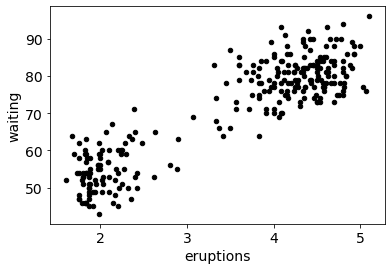

In [2]:
df = pd.read_csv('Data_HW9/faithful.csv')
df.plot.scatter(x = 'eruptions', y = 'waiting', c = 'black')
plt.show()

We use both variables `eruptions` and `waiting`. The plot above shows that there are two eruption patterns (clusters). Hence, we use a hidden Bernoulli random variable $Z_i \sim \text{Bern}(\pi)$ to indicate which pattern an observed eruption falls into. The corresponding distribution of `eruptions` and `waiting` can be described by a two-dimensional Gaussian --- either $N(\boldsymbol \mu_1, \boldsymbol \Sigma_1)$ or $N(\boldsymbol \mu_2, \boldsymbol \Sigma_2)$ --- depending on the outcome of $Z_i$. Here, the collection of parameters is $\boldsymbol \theta = \{\boldsymbol \mu_1, \boldsymbol \Sigma_1, \boldsymbol \mu_2, \boldsymbol \Sigma_2, \pi\}$, and we want to use the EM algorithm to estimate them.

## Part a) (20 Points) The E-Step

Based on the above assumption of eruption patterns, write down the full log-likelihood $\ell(\mathbf{x}, \mathbf{z} | \boldsymbol \theta)$. In the E-step, we need the conditional expectation 

$$g(\boldsymbol \theta | \boldsymbol \theta^{(k)}) = E_{\mathbf{Z} | \mathbf{x}, \boldsymbol \theta^{(k)}}[\ell(\mathbf{x}, \mathbf{Z} | \boldsymbol \theta)].$$ 

Provide the formulation of the above function. Derive the conditional expectation ($p_i$) of $\mathbf{Z}$ given $\mathbf{x}$ and $\boldsymbol \theta^{(k)}$, using notations in our lecture.

**Solution**:

Following our general notaion, we write the likelihood as:

$$ L (\mathbf{x}, \mathbf{z} | \boldsymbol \theta) =  \prod_{i = 1}^{n} \left[ \phi_{\mu_1, \Sigma_1} (\mathbf{x_i}) \right] ^ {1 - z_i} \left[ \phi_{\mu_2, \Sigma_2} (\mathbf{x_i}) \right] ^ {z_i} (1 - \pi)^{1 - z_i} (\pi)^{z_i} $$

Hence, the full log-likelihood becomes:

$$
\ell(\mathbf{x}, \mathbf{z} | \boldsymbol \theta) = \sum_{i = 1}^{n} (1 - z_i) \left[ - \frac{1}{2} \log |\Sigma_1| - \frac{1}{2}(x_i - \mu_1)^T \Sigma_1^{-1}(x_i - \mu_1) \right]  \\
+ (z_i) \left[ - \frac{1}{2} \log |\Sigma_2| - \frac{1}{2}(x_i - \mu_2)^T \Sigma_2^{-1}(x_i - \mu_2) \right] \\
+ \sum_{i = 1}^{n} (1 - z_i) \log(1 - \pi) + z_i\log(\pi)
$$

The E-Step function then becomes:

$$
 \begin{equation}
g(\boldsymbol \theta | \boldsymbol \theta^{(k)}) = E_{\mathbf{Z} | \mathbf{x}, \boldsymbol \theta^{(k)}}[\ell(\mathbf{x}, \mathbf{Z} | \boldsymbol \theta)] \\
g(\boldsymbol \theta | \boldsymbol \theta^{(k)}) = \sum_{i = 1}^{n} (1 - \hat{p_i}) \left[ - \frac{1}{2} \log |\Sigma_1| - \frac{1}{2}(x_i - \mu_1)^T \Sigma_1^{-1}(x_i - \mu_1) \right]  \\
+ (\hat{p_i}) \left[ - \frac{1}{2} \log |\Sigma_2| - \frac{1}{2}(x_i - \mu_2)^T \Sigma_2^{-1}(x_i - \mu_2) \right] \\
+ \sum_{i = 1}^{n} (1 - \hat{p_i}) \log(1 - \pi) + \hat{p_i}\log(\pi)
\tag{1}\end{equation}
$$ 

where:

$$\begin{equation}
\hat{p_i} := P(\mathbf{Z}_i = 1 | \mathbf{X}_i = \mathbf{x}_i , \boldsymbol \theta ^{(k)} )
= \frac{ \pi \phi_{\mu_2 , \Sigma_2}(x_i) }{ \pi \phi_{\mu_2 , \Sigma_2}(x_i) + (1 - \pi) \phi_{\mu_1 , \Sigma_1}(x_i) }
\tag{2}\end{equation}
$$

where $ \phi_{\mu , \Sigma}(\cdot) $ is the multivariate gaussian PDF and the parameter set $\boldsymbol \theta = \{\boldsymbol \mu_1, \Sigma_1, \mu_2, \Sigma_2, \pi\}$ is evaluated using the $ \boldsymbol \theta^{(k)} $ iteration.

## Part b) (30 Points) The M-Step

[10 points] Once we have $g(\boldsymbol \theta | \boldsymbol \theta^{(k)})$, the M-step is to re-calculate the maximum likelihood estimators of $\boldsymbol \mu_1$, $\boldsymbol \Sigma_1$, $\boldsymbol \mu_2$, $\boldsymbol \Sigma_2$ and $\pi$. You need to provide a derivation of these estimators. __Hint__: by taking the derivative of the objective function with respect to the parameters, the proof involves three tricks: 

  + $\text{Trace}(\beta^T \Sigma^{-1}\beta) = \text{Trace}(\Sigma^{-1}\beta \beta^T)$
  + $\frac{\partial}{\partial A} \log |A| = A^{-1}$
  + $\frac{\partial}{\partial A} \text{Trace}(BA) = B^T$
  
(Note: In this solution, hints (1) and (3) have not been used. Instead, a one-step derivative is computed using Equation (61) in the [Matrix Cookbook](http://www.math.uwaterloo.ca/~hwolkowi//matrixcookbook.pdf).)

**Solution**:

We now have the function $g(\boldsymbol \theta | \boldsymbol \theta^{(k)})$, and we want to find parameter estimates such that:

$$\theta^{(k+1)} = \underset{\theta}{\text{arg max  }} g(\boldsymbol \theta | \boldsymbol \theta^{(k)}) $$

Hence, we set $\frac{\partial g}{\partial \theta_i} = 0$ for each $\theta_i \in \boldsymbol \theta$, which gives the following updates:

1. For $\pi$:

We have $$\frac{\partial g}{\partial \pi} = 0$$ $$\sum_{i = 1}^{n} \frac{\hat{p_i}}{\pi} - \frac{1 - \hat{p_i}}{1 - \pi} = 0$$ Hence, 
$$\begin{equation}
\pi^{(k+1)} = \frac{1}{n}\sum_{i = 1}^{n} \hat{p_i}
\tag{3}\end{equation}
$$

2. For $\mu_1$ and $\mu_2$:

We have $$\frac{\partial g}{\partial \mu_1} = 0$$ 

$$\sum_{i = 1}^{n} (1-\hat{p_i})\left( -\frac{1}{2} \left( -2\Sigma_1^{-1}(x_i - \mu_1 \right) \right) = 0 $$

$$\sum_{i = 1}^{n} (1-\hat{p_i}) \Sigma_1^{-1}(x_i - \mu_1) = 0 $$

Which gives $$ \mu_1^{(k+1)} = \frac{\sum_{i = 1}^{n} (1-\hat{p_i}) x_i}{\sum_{i = 1}^{n} (1-\hat{p_i})} $$

And similarly, 
$$\begin{equation}
\mu_2^{(k+1)} = \frac{\sum_{i = 1}^{n} \hat{p_i} x_i}{\sum_{i = 1}^{n} \hat{p_i}}
\tag{4}\end{equation}
$$

3. For $\Sigma_1$ and $\Sigma_2$:

We have $$\frac{\partial g}{\partial \Sigma_1} = 0$$

$$ \sum_{i = 1}^{n} (1-\hat{p_i}) \left( - \frac{1}{2} \Sigma_1^{-1} - \frac{1}{2}\Sigma_1^{-1}(x_i - \mu_1)(x_i - \mu_1)^T \Sigma_1^{-1} \right) = 0 $$

$$ \sum_{i = 1}^{n} (1-\hat{p_i}) \left( I - (x_i - \mu_1)(x_i - \mu_1)^T \Sigma_1^{-1} \right) = 0$$

which simplifies to: $$ \Sigma_1^{(k+1)} = \frac{\sum_{i = 1}^{n} (1-\hat{p_i})(x_i - \mu_1)(x_i - \mu_1)^T}{\sum_{i = 1}^{n} (1-\hat{p_i})} $$

And similarly, $$\begin{equation} \Sigma_2^{(k+1)} = \frac{\sum_{i = 1}^{n} \hat{p_i}(x_i - \mu_2)(x_i - \mu_2)^T}{\sum_{i = 1}^{n}\hat{p_i}} \tag{5}\end{equation}$$

## Part c) (50 Points) Implementing the Algorithm

Implement the EM algorithm using the formula you just derived. Make sure that the following are addressed:

  * [5 Points] You need to give a reasonable initial value such that the algorithm converges. 
  * [10 Points] Make sure that you give proper comment on each step to clearly indicate which quantity the code is calculating.
  * [5 Points] Set up a convergence criteria under which the iteration stops.
  * [10 Points] Record the result (all the parameter estimates) for each iteration. Report the final parameter estimates.
  * [10 Points] Make four plots to demonstrate the fitted model and the updating process: your initial values, the first iteration, the second iteration, and the final results. The plots should intuitively demonstrate the fitted Gaussian distributions. For ideas of the plot, refer to the animation on the Wikipedia page. 
  * You may use other packages to calculate the Gaussian densities.
  
  
**Solution**:

All points are addressed in the code, except point 3. The convergence criterion used is the difference in log-likelihood between two iterations:

$$E_{\mathbf{Z} | \mathbf{x}, \boldsymbol \theta^{(k)}}[\ell(\mathbf{x}, \mathbf{Z} | \boldsymbol \theta)] \leq E_{\mathbf{Z} | \mathbf{x}, \boldsymbol \theta^{(k-1)}}[\ell(\mathbf{x}, \mathbf{Z} | \boldsymbol \theta)] + \delta
$$

for some pre-defined tolerance $\delta$.

In [3]:
#Function to plot results
def plot_results(X, means, covariances, title):
    color_iter = itertools.cycle(['tab:purple','tab:orange'])

    splot = plt.subplot(1, 1, 1)
    plt.scatter(X[:,0], X[:,1], s = 50, color = 'black')
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        plt.plot(means[i,0],means[i,1],'+', color = color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlabel ('Eruptions')
    plt.ylabel ('Waiting')

    fig = mpl.pyplot.gcf()
    fig.set_size_inches(6,4)
    plt.title(title)
    plt.show()

In [4]:
#The EM Algorithm
def emAlgo(mu1, mu2, sig1, sig2, pi, x, tol = 1e-05, maxitr = 100):
    def getP_iHat(mu1, mu2, sig1, sig2, pi, x):
        '''
        Takes in a vector of points x (n x 2)
        Returns a vector p (n x 1)
        Refer Equation (2)
        '''
        num = pi * mvrnorm.pdf(x, mu2, sig2)
        den = num + (1 - pi) * mvrnorm.pdf(x, mu1, sig1)
        return num/den
    
    def logL(mu1, mu2, sig1, sig2, pi, x, p_i):
        '''
        Takes in a vector of points x (n x 2)
        Returns the log-likelihood (scalar)
        Refer equation (1)
        '''
        p_i_dash = 1 - p_i
        sig1_inv = np.linalg.inv(sig1)
        sig2_inv = np.linalg.inv(sig2)
        logsig1 = math.log(np.linalg.det(sig1))
        logsig2 = math.log(np.linalg.det(sig2))
        sum1 = np.sum([p_i_dash[j] * (-0.5*logsig1 - 0.5*(x[j] -mu1).dot(sig1_inv.dot(x[j]-mu1))) for j in range(len(x))])
        sum2 = np.sum([p_i[j] * (-0.5*logsig2 - 0.5*(x[j] -mu2).dot(sig2_inv.dot(x[j]-mu2))) for j in range(len(x))])
        sum3 = np.sum(math.log(1 - pi)*p_i_dash)
        sum4 = np.sum(math.log(pi)*p_i)
        return sum1 + sum2 + sum3 + sum4
    
    def getMuUpdate(p_i, x):
        '''
        Updates mu based on equation (4)
        '''
        return np.sum(np.multiply(p_i.reshape(-1,1), x), axis = 0) / np.sum(p_i)
    
    def getSigmaUpdate(p_i, x, mu):
        '''
        Updates sigma based on equation (5)
        '''
        s = [p_i[j] * (x[j] - mu).reshape(-1,1).dot((x[j] - mu).reshape(1,-1)) for j in range(len(x))]
        return np.sum(s, axis = 0) / np.sum(p_i)

    results = {}
    for i in range(maxitr):
        results[i] = (mu1, mu2, sig1, sig2, pi)
        '''
        E-step
        Calculate the conditional distribution of the hidden variable z
        '''
        p_i = getP_iHat(mu1, mu2, sig1, sig2, pi, x)
        
        '''
        M-Step
        Parameter Updates
        '''
        pi_new             = np.mean(p_i)
        mu1_new, mu2_new   = getMuUpdate(1 - p_i, x) , getMuUpdate(p_i, x)
        sig1_new, sig2_new = getSigmaUpdate(1 - p_i, x, mu1) , getSigmaUpdate(p_i, x, mu2)
        
        if abs(logL(mu1, mu2, sig1, sig2, pi, x, p_i) - \
               logL(mu1_new, mu2_new, sig1_new, sig2_new, pi_new, x, p_i)) < tol:
            break
        else:
            pi = pi_new
            mu1, mu2 = mu1_new, mu2_new
            sig1, sig2 = sig1_new, sig2_new
            
    return results

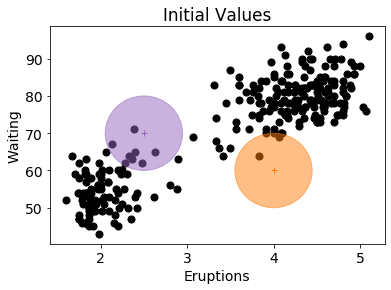

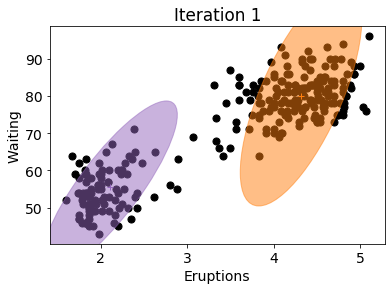

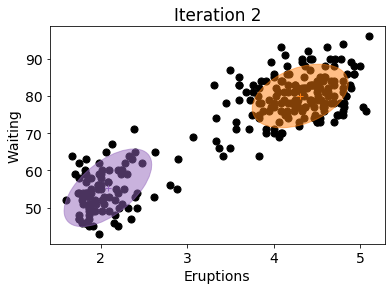

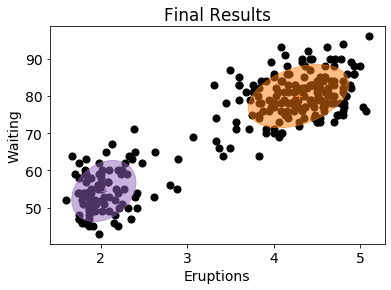

In [5]:
#Initial Values
mu1 = np.array([2.5, 70])
mu2 = np.array([4, 60])
sig1 = np.array([[0.1, 0],[0, 50]])
sig2 = np.array([[0.1, 0],[0, 50]])
x = df.values
pi = 0.5

resultsDict = emAlgo(mu1, mu2, sig1, sig2, pi, x)
finalItr = list(resultsDict.keys())[-1]
#Iterations whose results you want to plot
plotIdx = [0, 1, 2, finalItr]
titles = ['Initial Values'] + ['Iteration '+str(k) for k in range(1,len(plotIdx)-1)] + ['Final Results']

for idx, title in zip(plotIdx, titles):
    currItr = resultsDict[idx]
    means = np.append(currItr[0].reshape(1,-1), currItr[1].reshape(1,-1), axis = 0)
    covariances = np.append(currItr[2].reshape(2,-2,), currItr[3].reshape(2,-2,), axis = 0).reshape(2,2,2)
    plot_results(x, means, covariances, title)

Final parameter estimates:

$\mu_1 = \begin{bmatrix} 2.03 \\ 54.48 \end{bmatrix} $ ,
$\Sigma_1 = \begin{bmatrix} 0.069 & 0.43 \\ 0.43 & 33.70 \end{bmatrix} $ , 

$\mu_2 = \begin{bmatrix} 4.29 \\ 79.97 \end{bmatrix} $ ,
$\Sigma_2 = \begin{bmatrix} 0.169 & 0.94 \\ 0.94 & 36.03 \end{bmatrix} $ ,

$\pi = 0.644$